# Import the dataset from the archive

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
import sys, os

Mounted at /content/drive


In [ ]:
#if not os.path.isfile('/content/drive/MyDrive/archive.zip'):
!unzip "/content/drive/MyDrive/mp_data.zip" -d "/content/"

# Loading the dataset


### Loading data

**Import libraries**

In [3]:
import os
import logging


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [4]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 28  

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 25e-3            # The initial Learning Rate: 1e-3, the best result so far: 25e-3, Validation Accuracy: 0.46680497925311204, Test Accuracy: 0.46837193225025925
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy), initial value: 20
GAMMA = 0.9          # Multiplicative factor for learning rate step-down, initial value: 0.1

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [5]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      # Crops a central square patch of the image
                                      transforms.CenterCrop(224),
                                      # 224 because torchvision's AlexNet needs a 224x224 input!
                                      # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(),  # Turn PIL Image to torch.Tensor
                                      # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize(
                                          (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])


**Dataset Class**

In [6]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class MoviePosters(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(MoviePosters, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        # Open file in read only mode and read all lines
        file = open(self.split, "r")
        lines = file.readlines()

        # Filter out the lines which start with 'BACKGROUND_Google' as asked in the homework
        self.elements = [i for i in lines if not i.startswith('BACKGROUND_Google')]

        # Delete BACKGROUND_Google class from dataset labels
        self.classes = sorted(os.listdir(os.path.join(self.root, "")))
        # self.classes.remove("BACKGROUND_Google")


    def __getitem__(self, index):
        ''' 
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        img = pil_loader(os.path.join(self.root, self.elements[index].rstrip()))

        target = self.classes.index(self.elements[index].rstrip().split('/')[0])

        image, label = img, target # Provide a way to access image and label via index
                           # Image should be a PIL Image
                           # label can be int

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        # Provides a way to get the length (number of elements) of the dataset
        length =  len(self.elements)
        return length

**Prepare Dataset**

In [7]:
from sklearn.model_selection import train_test_split

DATA_DIR = 'movie_posters_dataset'

SPLIT_TRAIN = 'train.txt'

train_dataset_ = MoviePosters(
    DATA_DIR, split=SPLIT_TRAIN, transform=train_transform)

train_len_list = list(range(len(train_dataset_)))

train_indexes, val_indexes = train_test_split(train_len_list, shuffle=True, test_size=0.5)

train_dataset = Subset(train_dataset_, train_indexes)
val_dataset = Subset(train_dataset_, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))


Train Dataset: 19274
Valid Dataset: 19274


**Prepare Dataloaders**

In [8]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Prepare Network**

In [9]:
net = alexnet(pretrained=False)  # Loading AlexNet model, set pretrained

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
# nn.Linear in pytorch is a fully connected layer
net.classifier[6] = nn.Linear(4096, 28)
# The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 28 outputs
# It is strongly suggested to study torchvision.models.alexnet source code


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Prepare Training**

In [10]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE)  # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark  # Calling this optimizes runtime

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

train_loss_list_all = []
val_loss_list_all = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print("\n##################################################")
    print('Starting epoch {}/{}, LR = {}'.format(epoch +
          1, NUM_EPOCHS, scheduler.get_lr()))

    # Iterate over the dataset
    train_running_corrects = 0

    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train()  # Sets module in training mode

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad()  # Zero-ing the gradients

        # Forward pass to the network
        train_outputs = net(images)

        # Compute loss based on output and ground truth
        train_loss = criterion(train_outputs, labels)
        train_loss_list.append(train_loss.item())

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, train_loss.item()))

        # Compute gradients for each layer and update weights
        train_loss.backward()  # backward pass: computes gradients
        optimizer.step()  # update weights based on accumulated gradients

        current_step += 1

        # Get predictions
        _, train_preds = torch.max(train_outputs.data, 1)

        # Update Corrects
        train_running_corrects += torch.sum(train_preds ==
                                            labels.data).data.item()

    # Append train loss list
    train_loss_list_all.append(train_loss.item())

    # Calculate Accuracy
    accuracy_train = train_running_corrects / float(len(train_dataset))

    train_acc_list.append(accuracy_train)

    # Step the scheduler
    scheduler.step()

    ##############################################################################################################################
    ### VALIDATION AFTER EACH EPOCH ###

    # this will bring the network to GPU if DEVICE is cuda
    net = net.to(DEVICE)
    net.train(False)  # Set Network to evaluation mode

    val_running_corrects = 0
    for images, labels in tqdm(val_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        val_outputs = net(images)

        # Compute loss based on output and ground truth
        val_loss = criterion(val_outputs, labels)
        val_loss_list.append(val_loss.item())

        # Get predictions
        _, val_preds = torch.max(val_outputs.data, 1)

        # Update Corrects
        val_running_corrects += torch.sum(val_preds == labels.data).data.item()

    # Append val loss list
    val_loss_list_all.append(val_loss.item())

    # Calculate Accuracy
    accuracy_val = val_running_corrects / float(len(val_dataset))

    print('Validation Accuracy: {}'.format(accuracy_val))

    val_acc_list.append(accuracy_val)



##################################################
Starting epoch 1/30, LR = [0.025]


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Step 0, Loss 3.335606336593628
Step 10, Loss 3.089062452316284
Step 20, Loss 2.273801803588867
Step 30, Loss 2.352163076400757
Step 40, Loss 2.2152345180511475
Step 50, Loss 2.166625738143921
Step 60, Loss 2.236783504486084
Step 70, Loss 2.187218189239502


100%|██████████| 76/76 [01:02<00:00,  1.22it/s]

Validation Accuracy: 0.24686105634533567

##################################################
Starting epoch 2/30, LR = [0.025]


Step 80, Loss 2.307314395904541
Step 90, Loss 2.2449522018432617
Step 100, Loss 2.290147304534912
Step 110, Loss 2.1305229663848877
Step 120, Loss 2.0715882778167725
Step 130, Loss 2.136690855026245
Step 140, Loss 2.320369005203247


100%|██████████| 76/76 [01:04<00:00,  1.19it/s]

Validation Accuracy: 0.24846944069731244

##################################################
Starting epoch 3/30, LR = [0.025]


Step 150, Loss 2.1682631969451904
Step 160, Loss 2.104208469390869
Step 170, Loss 2.162015199661255
Step 180, Loss 2.203000068664551
Step 190, Loss 2.2325549125671387
Step 200, Loss 2.1407108306884766
Step 210, Loss 2.0515692234039307
Step 220, Loss 2.1194894313812256


100%|██████████| 76/76 [01:07<00:00,  1.12it/s]

Validation Accuracy: 0.30050845698868944

##################################################
Starting epoch 4/30, LR = [0.025]


Step 230, Loss 2.113720655441284
Step 240, Loss 2.2102153301239014
Step 250, Loss 2.1189184188842773
Step 260, Loss 2.1193480491638184
Step 270, Loss 2.1321115493774414
Step 280, Loss 2.204763412475586
Step 290, Loss 2.136692523956299


100%|██████████| 76/76 [01:04<00:00,  1.17it/s]

Validation Accuracy: 0.2980180554114351

##################################################
Starting epoch 5/30, LR = [0.025]


Step 300, Loss 2.081615686416626
Step 310, Loss 2.158093214035034
Step 320, Loss 2.157892942428589
Step 330, Loss 2.3006956577301025
Step 340, Loss 2.0961995124816895
Step 350, Loss 2.2006676197052
Step 360, Loss 2.0551369190216064
Step 370, Loss 2.0861306190490723


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.30206495797447336

##################################################
Starting epoch 6/30, LR = [0.025]


Step 380, Loss 2.1319217681884766
Step 390, Loss 2.100126028060913
Step 400, Loss 2.277381420135498
Step 410, Loss 2.085348606109619
Step 420, Loss 2.134747266769409
Step 430, Loss 2.1361641883850098
Step 440, Loss 2.110654354095459


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.30434782608695654

##################################################
Starting epoch 7/30, LR = [0.025]


Step 450, Loss 2.1313719749450684
Step 460, Loss 2.2235000133514404
Step 470, Loss 2.0672526359558105
Step 480, Loss 2.0497214794158936
Step 490, Loss 2.089207172393799
Step 500, Loss 2.2540762424468994
Step 510, Loss 2.1559553146362305
Step 520, Loss 2.1724414825439453


100%|██████████| 76/76 [01:09<00:00,  1.10it/s]

Validation Accuracy: 0.3187714018885545

##################################################
Starting epoch 8/30, LR = [0.025]


Step 530, Loss 2.0436630249023438
Step 540, Loss 2.0655999183654785
Step 550, Loss 2.1103527545928955
Step 560, Loss 2.200127363204956
Step 570, Loss 2.1681222915649414
Step 580, Loss 2.041142702102661
Step 590, Loss 2.1469643115997314


100%|██████████| 76/76 [01:10<00:00,  1.08it/s]

Validation Accuracy: 0.323544671578292

##################################################
Starting epoch 9/30, LR = [0.025]


Step 600, Loss 2.151874303817749
Step 610, Loss 2.1038219928741455
Step 620, Loss 2.111590623855591
Step 630, Loss 2.0681545734405518
Step 640, Loss 2.104097604751587
Step 650, Loss 2.1806423664093018
Step 660, Loss 2.1288716793060303
Step 670, Loss 2.1155850887298584


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.32204005395870083

##################################################
Starting epoch 10/30, LR = [0.025]


Step 680, Loss 2.121663808822632
Step 690, Loss 2.0606625080108643
Step 700, Loss 2.0732836723327637
Step 710, Loss 2.21372652053833
Step 720, Loss 2.0402185916900635
Step 730, Loss 2.1172945499420166
Step 740, Loss 2.0766537189483643


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.3164885337760714

##################################################
Starting epoch 11/30, LR = [0.020250000000000004]


Step 750, Loss 2.162599802017212
Step 760, Loss 2.1055381298065186
Step 770, Loss 2.0525572299957275
Step 780, Loss 2.009803295135498
Step 790, Loss 1.9930262565612793
Step 800, Loss 2.128901958465576
Step 810, Loss 2.035691738128662
Step 820, Loss 2.080498695373535


100%|██████████| 76/76 [01:11<00:00,  1.07it/s]

Validation Accuracy: 0.33013385908477744

##################################################
Starting epoch 12/30, LR = [0.022500000000000003]


Step 830, Loss 2.192732810974121
Step 840, Loss 2.043262243270874
Step 850, Loss 2.0776968002319336
Step 860, Loss 2.1756510734558105
Step 870, Loss 2.041288375854492
Step 880, Loss 2.027317762374878
Step 890, Loss 2.0573537349700928


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.3304451592819342

##################################################
Starting epoch 13/30, LR = [0.022500000000000003]


Step 900, Loss 2.1113295555114746
Step 910, Loss 2.14267897605896
Step 920, Loss 2.0605673789978027
Step 930, Loss 1.9850447177886963
Step 940, Loss 2.0428414344787598
Step 950, Loss 1.9913616180419922
Step 960, Loss 2.0022809505462646
Step 970, Loss 2.031463146209717


100%|██████████| 76/76 [01:11<00:00,  1.07it/s]

Validation Accuracy: 0.32961502542284943

##################################################
Starting epoch 14/30, LR = [0.022500000000000003]


Step 980, Loss 1.9917725324630737
Step 990, Loss 2.0735106468200684
Step 1000, Loss 2.0902211666107178
Step 1010, Loss 2.066744089126587
Step 1020, Loss 2.0641794204711914
Step 1030, Loss 2.0756218433380127
Step 1040, Loss 2.1338982582092285


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.3305489260143198

##################################################
Starting epoch 15/30, LR = [0.022500000000000003]


Step 1050, Loss 2.0060250759124756
Step 1060, Loss 1.8802268505096436
Step 1070, Loss 2.096693515777588
Step 1080, Loss 2.146254062652588
Step 1090, Loss 2.1308751106262207
Step 1100, Loss 2.080941677093506
Step 1110, Loss 2.0466983318328857
Step 1120, Loss 2.0547261238098145


100%|██████████| 76/76 [01:08<00:00,  1.10it/s]

Validation Accuracy: 0.33252049392964617

##################################################
Starting epoch 16/30, LR = [0.022500000000000003]


Step 1130, Loss 2.0600810050964355
Step 1140, Loss 1.9676892757415771
Step 1150, Loss 2.0837531089782715
Step 1160, Loss 2.0588386058807373
Step 1170, Loss 2.0231173038482666
Step 1180, Loss 2.0317797660827637
Step 1190, Loss 1.9822359085083008


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.3332468610563453

##################################################
Starting epoch 17/30, LR = [0.022500000000000003]


Step 1200, Loss 2.1225528717041016
Step 1210, Loss 1.9858729839324951
Step 1220, Loss 2.0316808223724365
Step 1230, Loss 2.079294204711914
Step 1240, Loss 2.0496225357055664
Step 1250, Loss 1.9505243301391602
Step 1260, Loss 2.0365235805511475
Step 1270, Loss 1.9962502717971802


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.3345958285773581

##################################################
Starting epoch 18/30, LR = [0.022500000000000003]


Step 1280, Loss 1.9880151748657227
Step 1290, Loss 2.0129730701446533
Step 1300, Loss 2.0080103874206543
Step 1310, Loss 2.087641954421997
Step 1320, Loss 1.9010367393493652
Step 1330, Loss 2.163496971130371
Step 1340, Loss 2.0715250968933105


100%|██████████| 76/76 [01:09<00:00,  1.10it/s]

Validation Accuracy: 0.33485524540832207

##################################################
Starting epoch 19/30, LR = [0.022500000000000003]


Step 1350, Loss 2.057687520980835
Step 1360, Loss 1.9937225580215454
Step 1370, Loss 2.0360000133514404
Step 1380, Loss 2.104794502258301
Step 1390, Loss 2.0614213943481445
Step 1400, Loss 1.9867154359817505
Step 1410, Loss 2.012397289276123
Step 1420, Loss 2.035775899887085


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.3393172149009028

##################################################
Starting epoch 20/30, LR = [0.022500000000000003]


Step 1430, Loss 2.0310373306274414
Step 1440, Loss 1.9909946918487549
Step 1450, Loss 2.1242644786834717
Step 1460, Loss 2.021611452102661
Step 1470, Loss 1.9620790481567383
Step 1480, Loss 1.9443604946136475
Step 1490, Loss 1.932495355606079


100%|██████████| 76/76 [01:10<00:00,  1.08it/s]

Validation Accuracy: 0.3410293659852651

##################################################
Starting epoch 21/30, LR = [0.018225000000000005]


Step 1500, Loss 2.0717976093292236
Step 1510, Loss 1.8176237344741821
Step 1520, Loss 2.0578672885894775
Step 1530, Loss 2.0254809856414795
Step 1540, Loss 2.023378849029541
Step 1550, Loss 1.9859240055084229
Step 1560, Loss 2.1455812454223633
Step 1570, Loss 2.0253429412841797


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.3425858669710491

##################################################
Starting epoch 22/30, LR = [0.020250000000000004]


Step 1580, Loss 2.0781197547912598
Step 1590, Loss 2.0752217769622803
Step 1600, Loss 1.9839098453521729
Step 1610, Loss 2.1003053188323975
Step 1620, Loss 2.0167582035064697
Step 1630, Loss 2.0278549194335938
Step 1640, Loss 2.0934629440307617


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.34014734875998753

##################################################
Starting epoch 23/30, LR = [0.020250000000000004]


Step 1650, Loss 1.9803311824798584
Step 1660, Loss 1.8639945983886719
Step 1670, Loss 2.0629773139953613
Step 1680, Loss 2.0530662536621094
Step 1690, Loss 2.0158379077911377
Step 1700, Loss 1.930463433265686
Step 1710, Loss 1.975386381149292
Step 1720, Loss 2.024528980255127


100%|██████████| 76/76 [01:09<00:00,  1.09it/s]

Validation Accuracy: 0.32862924146518624

##################################################
Starting epoch 24/30, LR = [0.020250000000000004]


Step 1730, Loss 2.031867027282715
Step 1740, Loss 1.899789571762085
Step 1750, Loss 1.968131184577942
Step 1760, Loss 1.999192237854004
Step 1770, Loss 1.8998651504516602
Step 1780, Loss 1.9775974750518799
Step 1790, Loss 1.9783157110214233


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.3157102832831794

##################################################
Starting epoch 25/30, LR = [0.020250000000000004]


Step 1800, Loss 2.0094456672668457
Step 1810, Loss 1.9368937015533447
Step 1820, Loss 2.1434197425842285
Step 1830, Loss 2.0022552013397217
Step 1840, Loss 1.6803395748138428
Step 1850, Loss 2.025336742401123
Step 1860, Loss 1.8249115943908691
Step 1870, Loss 1.864638328552246


100%|██████████| 76/76 [01:10<00:00,  1.08it/s]

Validation Accuracy: 0.3125972813116115

##################################################
Starting epoch 26/30, LR = [0.020250000000000004]


Step 1880, Loss 1.9317100048065186
Step 1890, Loss 1.927029013633728
Step 1900, Loss 1.9601380825042725
Step 1910, Loss 1.884892463684082
Step 1920, Loss 1.9992315769195557
Step 1930, Loss 1.9838392734527588
Step 1940, Loss 1.9845577478408813


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.34699595309743697

##################################################
Starting epoch 27/30, LR = [0.020250000000000004]


Step 1950, Loss 1.8851066827774048
Step 1960, Loss 1.9069912433624268
Step 1970, Loss 1.9434477090835571
Step 1980, Loss 1.959188461303711
Step 1990, Loss 1.897402048110962
Step 2000, Loss 1.9700018167495728
Step 2010, Loss 1.778641700744629
Step 2020, Loss 2.0628931522369385


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.3411850160838435

##################################################
Starting epoch 28/30, LR = [0.020250000000000004]


Step 2030, Loss 2.0455687046051025
Step 2040, Loss 1.8900530338287354
Step 2050, Loss 1.8511794805526733
Step 2060, Loss 1.9870665073394775
Step 2070, Loss 1.9489109516143799
Step 2080, Loss 1.8412870168685913
Step 2090, Loss 1.9992865324020386


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.33584102936598526

##################################################
Starting epoch 29/30, LR = [0.020250000000000004]


Step 2100, Loss 1.8843917846679688
Step 2110, Loss 1.9064197540283203
Step 2120, Loss 1.675487995147705
Step 2130, Loss 2.039738416671753
Step 2140, Loss 1.826578140258789
Step 2150, Loss 1.9145387411117554
Step 2160, Loss 2.0715835094451904
Step 2170, Loss 1.9296200275421143


100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.3430009339005915

##################################################
Starting epoch 30/30, LR = [0.020250000000000004]


Step 2180, Loss 1.858731746673584
Step 2190, Loss 1.8166508674621582
Step 2200, Loss 1.8039753437042236
Step 2210, Loss 1.940617561340332
Step 2220, Loss 1.8760732412338257
Step 2230, Loss 1.8577966690063477
Step 2240, Loss 1.833130121231079


100%|██████████| 76/76 [01:10<00:00,  1.08it/s]

Validation Accuracy: 0.33604856283075646


**Validation**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy_val = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy_val))

100%|██████████| 76/76 [01:08<00:00,  1.11it/s]

Validation Accuracy: 0.33604856283075646


**Plots**

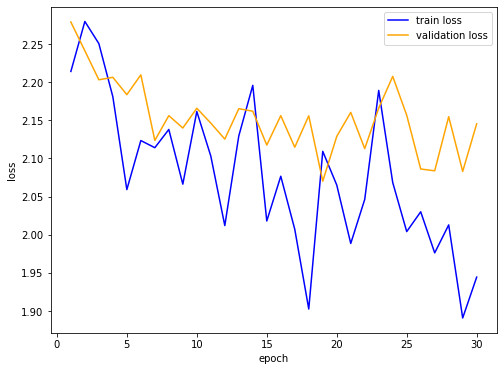

In [13]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [8, 6]

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1, len(train_loss_list_all)+1), train_loss_list_all, color='blue', label='train loss')
plt.plot(range(1, len(val_loss_list_all)+1), val_loss_list_all, color='orange', label='validation loss')
plt.legend(loc='upper right')
plt.show()

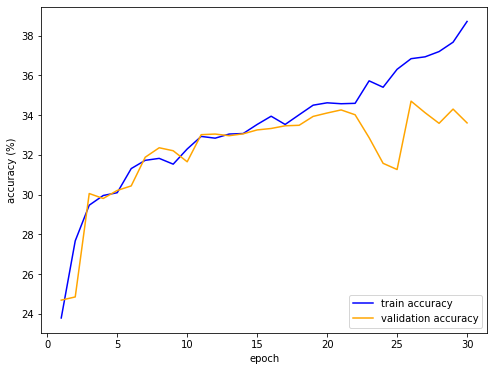

In [14]:
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.plot(range(1, len(train_acc_list)+1), [x * 100 for x in train_acc_list], color='blue', label='train accuracy')
plt.plot(range(1, len(val_acc_list)+1), [x * 100 for x in val_acc_list], color='orange', label='validation accuracy')
plt.legend(loc='lower right')
plt.show()